# Exercise Sheet 8: Generative Adversarial Networks

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torch.optim as optim

from sklearn.manifold import TSNE
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# folder path
data_path = './data'
model_path = './model'
result_path = './results'

# random seed np/torch
seed = 42
random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# hyperparameters
img_size = 32
latent_dim = 100
batch_size = 64
num_epochs = 5
lr = 0.0002
momentum = 0.5
betas = (0.5, 0.999)


# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Create folder if not exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(result_path):
    os.makedirs(result_path)

#### Task 1.1: Derive optial discriminator D*

Use equation (1) as a starting point to derive the optimal discriminator D∗ in terms of data probability pdata (x) and generator probability pG (x). 
Assume generator G is fixed.

The objective function V(D,G) is:


$V(D,G) = E_{x~p_{data}(x)} [log (D(x))] + E_{z~p(z)} [log (1 - D(G(z)))]$

Rewriting the objective function in terms of p_{data}(x) and p_z(x):

$
V(D,G) = \int{p_{data}(x) log(D(x)) dx + \int{p_g(x) log(1 - D(g(z))) dx}} \\
= \int{p_{data}(x) log(D(x)) dx + p_g(x) log(1-D(x)) dx}
$

#### Task 1.2: Find optimal point minimizing V

Use the obtained D∗ to find the optimal point minimizing V. 
What value does D∗ have at this point and what would this value imply?


Taking the derivative of V with respect to D(x) and setting it to zero:

$\frac{dV}{dD(x)} = \frac{p_{data}(x)}{D(x)} - \frac{p_g(x)}{(1 - D(x))} = 0$

Solving for D*(x):

$D_G*(x) = \frac{p_{data}(x)}{(p_{data}(x) + p_g(x))}$

#### Task 2: Training a GAN

* Use Adam optimizer with a learning rate of 0.0001 and β1 = 0.5.
* Fashion-MNIST has a standard resolution of 28 × 28 so make sure to resize it to 32 × 32
* You may have to adapt the DCGAN architecture slightly to generate 32×32 images instead of 64 × 64
* Using spectral normalization on the weights of the Discriminator can help with mode collapse and make training more stable
* You should already see decent results after a couple of epochs.

In [10]:
# Download Fashion MNIST dataset

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((img_size, img_size)),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(data_path, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

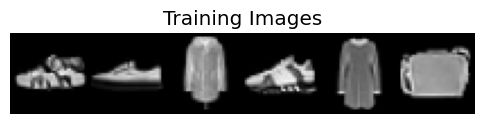

In [11]:
# Get a batch of real images
real_batch = next(iter(trainloader))
images, _ = real_batch

# Normalize the images to [0, 1] range for plotting
images = (images + 1) / 2

# Create a grid of images
grid = torchvision.utils.make_grid(images[:6], padding=2, normalize=False)

# Transpose the grid to match the expected shape for imshow
grid = np.transpose(grid.cpu().numpy(), (1, 2, 0))

# Plot the grid of images
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)
plt.savefig(os.path.join(result_path, 'training_images.png'))
plt.show()


In [12]:
# Spectral Normalization - weight normalization
# https://arxiv.org/abs/1802.05957

class SpectralNormConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super(SpectralNormConv2d, self).__init__(*args, **kwargs)
        self.weight = spectral_norm(self.weight)

class SpectralNormLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super(SpectralNormLinear, self).__init__(*args, **kwargs)
        self.weight = spectral_norm(self.weight)

In [13]:
class Generator(nn.Module):
    """ Generator generates fake images from random noise."""
    def __init__(self):
        super(Generator, self).__init__()
        # Input is 100, going into a convolution.
        self.conv1 = nn.ConvTranspose2d(100, 512, (4, 4), (1, 1), (0, 0), bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        # state size. 512 x 4 x 4
        self.conv2 = nn.ConvTranspose2d(512, 256, (4, 4), (2, 2), (1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(256)
         # state size. 256 x 8 x 8
        self.conv3 = nn.ConvTranspose2d(256, 128, (4, 4), (2, 2), (1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        # state size. 128 x 16 x 16
        self.conv4 = nn.ConvTranspose2d(128, 64, (4, 4), (2, 2), (1, 1), bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        # state size. 64 x 32 x 32
        self.conv5 = nn.ConvTranspose2d(64, 1, (4, 4), (1, 1), (0, 0), bias=False)
        # state size. 1 x 32 x 32

    def forward(self, z):
        # Reshape the input
        z = z.view(-1, 100, 1, 1)
        x = F.relu(self.bn1(self.conv1(z)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        # Tanh activation function
        x = torch.tanh(self.conv5(x))
        return x

class Discriminator(nn.Module):
    """ Discriminator learns to distinguish between real and fake images."""
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input is 1 x 32 x 32
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(1, 64, (4, 4), (2, 2), (1, 1), bias=False))
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(64, 128, (4, 4), (2, 2), (1, 1), bias=False))
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(128, 256, (4, 4), (2, 2), (1, 1), bias=False))
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(256, 1, (4, 4), (1, 1), (0, 0), bias=False))

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = self.conv4(x)
        # Flatten the output
        x = x.view(-1, 1)
        # Sigmoid activation function
        x = nn.functional.sigmoid(x)
        return x

class DCGAN(nn.Module):
    """ DCGAN combines a generator and discriminator."""
    def __init__(self, latent_dim=100, img_size=32, lr=1e-4, betas=(0.5, 0.999), device=None):
        super(DCGAN, self).__init__()

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._device = device
        self._lr = lr
        self._betas = betas
        self._latent_dim = latent_dim
        self._img_size = img_size
        self._fixed_noise = torch.randn(self._img_size, self._latent_dim, 1, 1, device=self._device)

        # Initialize generator and discriminator
        self.generator = Generator().to(self._device)
        self.discriminator = Discriminator().to(self._device)

        # Initialize weights
        self.generator.apply(self.weights_init)
        self.discriminator.apply(self.weights_init)

        # Initialize optimizers and criterion
        self.criteria = nn.BCELoss()
        self.binary_accuracy = nn.BCEWithLogitsLoss()
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=self._lr, betas=self._betas)
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self._lr, betas=self._betas)

    def forward(self, z):
        return self.generator(z)

    def sample_random_z(self, n):
        sample = torch.randn(n, self._latent_dim, 1, 1, device=self._device)
        return sample

    def sample_fixed_z(self):
        return self._fixed_noise
    
    def sample_G(self, n=1, type='fixed'):
        # Sample random noise z
        if type == 'fixed':
            z = self.sample_fixed_z()
        else:
            z = self.sample_random_z(n)
        # Generate fake images
        fake_img = self.generator(z)
        return fake_img

    def adversarial_loss(self, y_hat, y):
        # binary cross-entropy loss
        return self.criteria(y_hat, y)

    def generator_loss(self, fake):
        # Generator loss
        return self.adversarial_loss(self.discriminator(fake), torch.ones(fake.size(0), 1, device=self._device))
    
    def discriminator_loss(self, real, fake):
        # Discriminator loss
        real_pred = self.discriminator(real)
        real_loss = self.adversarial_loss(real_pred, torch.ones(real.size(0), 1, device=self._device))
        fake_pred = self.discriminator(fake.detach())
        fake_loss = self.adversarial_loss(fake_pred, torch.zeros(fake.size(0), 1, device=self._device))
        return real_loss + fake_loss

    def train_step(self, real_images):
        # ============================================================= #
        # ================== Train the discriminator ================== #
        # ============================================================= #
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        # Train the discriminator with real images
        self.optimizer_D.zero_grad()
        real_pred = self.discriminator(real_images)
        real_loss = self.adversarial_loss(real_pred, torch.ones(real_images.size(0), 1, device=self._device))
        real_acc = self.binary_accuracy(real_pred, torch.ones(real_images.size(0), 1, device=self._device))

        # Train the discriminator with fake images
        z = self.sample_random_z(real_images.size(0))
        fake_images = self.generator(z)
        fake_pred = self.discriminator(fake_images.detach())
        fake_loss = self.adversarial_loss(fake_pred, torch.zeros(fake_images.size(0), 1, device=self._device))
        fake_acc = self.binary_accuracy(fake_pred, torch.zeros(fake_images.size(0), 1, device=self._device))

        # Total Discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        self.optimizer_D.step()

        # Compute overall avg. accuracy
        acc = (real_acc + fake_acc) / 2

        # ============================================================= #
        # ===================== Train the generator =================== #
        # ============================================================= #
        # (2) Update G network: maximize log(D(G(z)))
        
        # Train the generator with random noise z
        self.optimizer_G.zero_grad()
        z = self.sample_random_z(real_images.size(0))
        fake = self.generator(z)

        # Generator loss
        g_loss = self.adversarial_loss(self.discriminator(fake), torch.ones(fake.size(0), 1, device=self._device))
        g_loss.backward()
        self.optimizer_G.step()

        return d_loss, g_loss, real_acc, fake_acc, acc

    # custom weights initialization called on ``netG`` and ``netD``
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def plot(self, n=25, save=False, path='results/result.png'):
        with torch.no_grad():
            z = self.sample_random_z(n)
            fake = self.generator(z).cpu()
            fake = fake.numpy()
            fig, axes = plt.subplots(5, 5, figsize=(10, 10))
            fig.suptitle('Generated Images')
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake[i, 0], cmap='gray')  # Reshape to (32, 32)
                ax.axis('off')
                ax.title.set_text(f'Image {i+1}')
            if save:
                plt.savefig(path)
            plt.show()


In [14]:
# Initialize DCGAN
dcgan = DCGAN(latent_dim=latent_dim, img_size=img_size, lr=lr, betas=betas, device=device)

d_fake_img_acc = []
d_real_img_acc = []
d_training_losses = []
g_training_losses = []

fake_img_list = []

# Train DCGAN
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)

        # Train the DCGAN
        d_loss, g_loss, real_acc, fake_acc, acc = dcgan.train_step(images)

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, num_epochs, i+1, len(trainloader), d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        d_training_losses.append(d_loss.item())
        g_training_losses.append(g_loss.item())

        # Save Discriminator Accuracy for plotting later
        d_fake_img_acc.append(fake_acc.item())
        d_real_img_acc.append(real_acc.item())

        # Collect G's output on a fixed_noise sample
        if (i+1) % (len(trainloader) // 100) == 0 or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = dcgan.sample_G(type='fixed').detach().cpu()
            fake_img_list.append(fake)

# Plot some images generated by the DCGAN
dcgan.plot(n=25, save=True, path=result_path + '/dcgan_train_results.png')

# Save the model under model_path
dcgan.save(model_path + '/dcgan.pth')


Epoch [0/5], Step [100/938], d_loss: 0.1822, g_loss: 4.3886


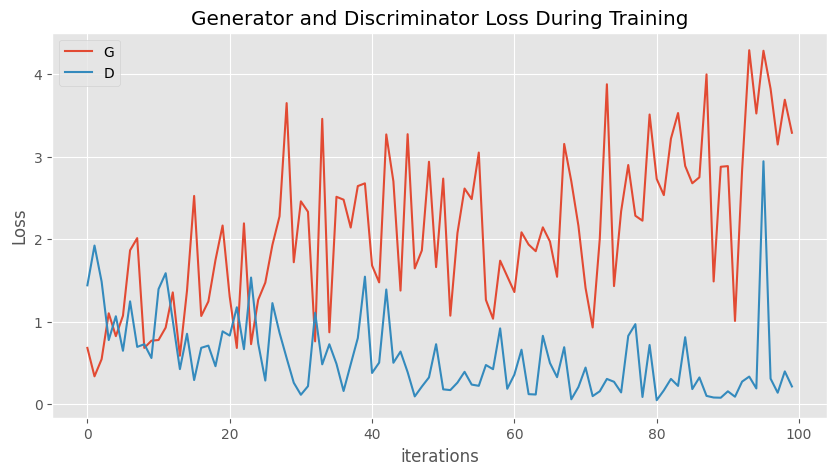

In [ ]:
# Plot evolution of the training losses for the generator and discriminator
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_training_losses, label="G")
plt.plot(d_training_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(result_path + '/loss.png')
plt.show()

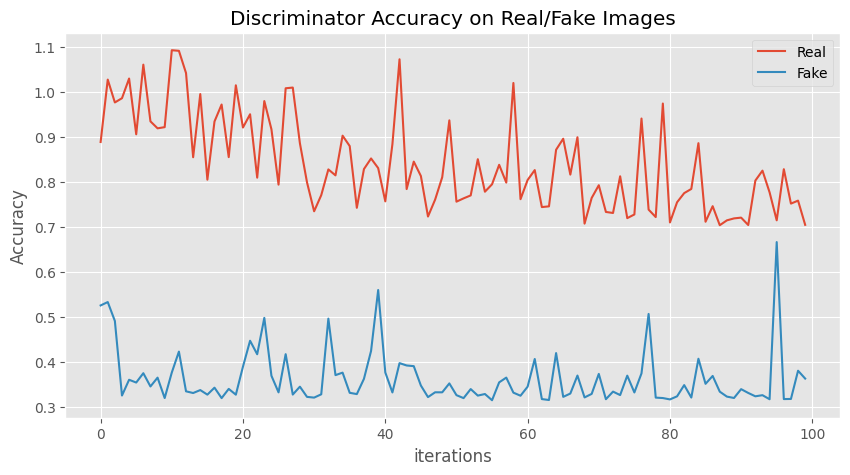

In [ ]:
# Plot classification accuracy of the discriminator on real/fake samples
plt.figure(figsize=(10, 5))
plt.title("Discriminator Accuracy on Real/Fake Images")
plt.plot(d_fake_img_acc, label="Real")
plt.plot(d_real_img_acc, label="Fake")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(result_path + '/accuracy.png')
plt.show()


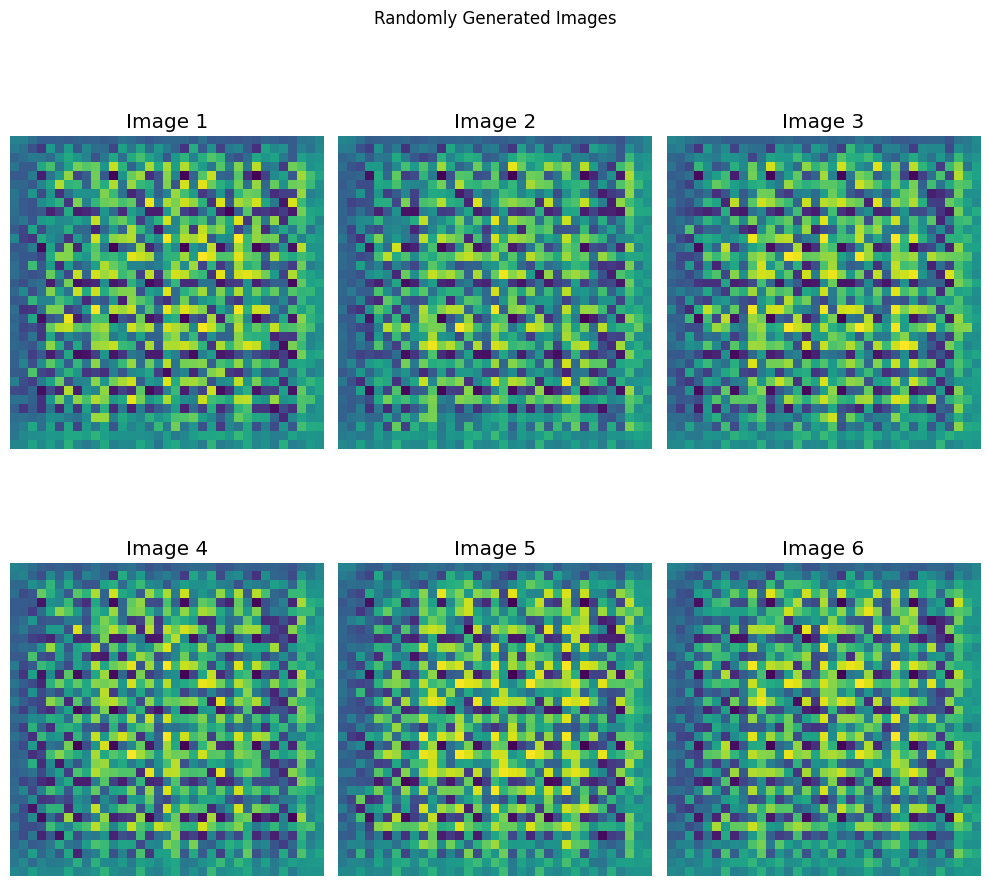

In [ ]:
# Plot 6 randomly synthesized images from the generator in a grid
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
fig.suptitle("Randomly Generated Images")
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(fake_img_list[-1][i], (1, 2, 0)))
    ax.axis('off')
    ax.title.set_text(f"Image {i+1}")
plt.tight_layout()
plt.savefig(result_path + '/generated_images.png')
plt.show()


In [ ]:
# Plot collected images for evolution of the generator during training
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Generated Images")
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(img_list[i][0], (1, 2, 0)))
    ax.axis('off')
    ax.title.set_text(f"Image {i+1}")
plt.tight_layout()
plt.savefig(result_path + '/generated_images_evolution.png')
plt.show()

In [ ]:
# Plot the t-SNE visualization of the features extracted from the real, fake, and generated images
# Select minimum of 5 classes from Fashion MNIST

# 5 classes of Fashion MNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']
class_indices = {name: i for i, name in enumerate(classes)}

# Load the pretrained model and remove the last layer
resnet18 = torchvision.models.resnet18(pretrained=True)
# Update the first layer to accept grayscale images
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1]).to(device)
resnet18.eval()

# Extract features from the last convolutional layer of the model
def get_features(model, dataloader, class_indices):
    features = []
    labels = []
    for images, labels_ in dataloader:
        labels = np.array([class_indices[classes[l]] for l in labels_])
        images = images.to(device)
        with torch.no_grad():
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten the output
        features.append(output)
        labels.append(labels)
    return torch.cat(features).cpu().numpy(), torch.cat(labels).cpu().numpy()

# Extract features from the train and test splits for the selected classes
train_features, train_labels = get_features(resnet18, trainloader, class_indices)
test_features, test_labels = get_features(resnet18, testloader, class_indices)

# Generate images using the generator and extract features
n = 10000
z = dcgan.sample_random_z(n)
fake_images = dcgan.generator(z)
fake_features = resnet18(fake_images).view(n, -1).cpu().numpy()

# Concatenate the features
features = np.concatenate([train_features, test_features, fake_features])
labels = np.concatenate([train_labels, test_labels, np.ones(n) * len(class_indices)])


/Users/janinaalicamattes/miniforge3/envs/pytorch-py11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/janinaalicamattes/miniforge3/envs/pytorch-py11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(features)

In [ ]:
# Plot the t-SNE embedding
plt.figure(figsize=(10, 10))
plt.title("t-SNE Embedding of Real and Fake Images")
for i in range(11):
    plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], label=str(i))
plt.legend()
plt.savefig(result_path + '/tsne.png')
plt.show()

In [ ]:
# Plot the classification accuracy on generated data using the previous ResNet18 classifier
acc = []
n = 10000

# Evaluate the classifier on the generated images
for i in range(0, n, batch_size):
    with torch.no_grad():
        output = resnet18(fake_img_list[i:i+batch_size])
        output = output.view(output.size(0), -1)
        pred = torch.argmax(output, 1)
        acc.append((pred == 10).sum().item() / batch_size)

# Plot the classification accuracy
plt.figure(figsize=(10, 5))
plt.title("Classification Accuracy on Generated Images")
plt.plot(acc)
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.savefig(result_path + '/classification_accuracy.png')
plt.show()

NameError: name 'fake_img_list' is not defined